# Lab 4: Transfer Learning and BERT!

11/20/2023, Ankit Ramakrishnan, Harshitha Somala, Nidhi Bodar, Felix Muzny

Due on: 11/21/2023 @ 9pm

Agenda
------
+ Get an overview of the BERT architecture
+ Download and play with a pre-trained BERT model
+ Train your own network that has a pre-trained BERT component
+ Play with some parameters!


Summary
----
This lab will guide you through the setup and uses of pretrained models in `Tensorflow` and `transformers`. In this lab we focus on BERT (https://github.com/google-research/bert/) an __encoder only transformer model__. We will use the pretrained model to extract features from text and use these features to train a classifier to classify different types of data. We will setup a binary classifier on the IMDB dataset. You will be working on training new models on the other datasets.

# Task 0: Who is in your group?

Please work in groups of up to 3 people!

6120: Anisha Kumari Kushwaha
6120: Sarthak Kagliwal

TASK 1: BERT questions
---

Before we dive into the code, we'd like you to take a moment to familiarize yourself with the architecture of BERT.

Take a look at the following resources as a group:
- [Illustrated BERT](http://jalammar.github.io/illustrated-bert/)
- SLP Chapter 11.1
- [BERT paper](https://aclanthology.org/N19-1423/)

Answer the questions in the next cell about the BERT architecture.

1. What does BERT stand for?

    Answer: Bidirectional Encoder Representations from Transformers
2. What task is the BERT pre-trained model trained on?

    Answer: BERT is pre-trained on a masked language model task.
3. How many parameters does BERT_{BASE} have? BERT_{LARGE}?   
    Answer: BERT_BASE has 110 million parameters, while BERT_LARGE has 340 million parameters.
4. What is the architecture of BERT_{BASE}? (what kind of neural network is it, what are the relevant dimensionality numbers?)  
    Answer: BERT_BASE has 12 layers, a hidden size of 768, 12 attention heads, and a total of 110 million parameters.
5. What can we feed as input to BERT?

    Answer: BERT takes tokenized text as input, including special tokens like [CLS] and [SEP], with optional padding for consistent length.
6. What is the output of BERT?  
    Answer: The output of BERT is contextualized representations for each token in the input sequence, with the [CLS] token often used for downstream tasks.
7. If we want to use BERT to help with a classification task, what is a high-level description of what we'll do? (2 - 3 sentences.)  
    Answer: For a classification task using BERT, you would first tokenize and prepare your input text, including the addition of special tokens like [CLS]. Then, you would feed the tokenized sequence into BERT, extract the contextualized representation of the [CLS] token, and pass it through a classification layer (e.g., a softmax layer) to obtain class probabilities. Finally, you can train the model using labeled data and fine-tune the classification layer for the specific task.

Installation Intermission
----

In [1]:
# make sure that the correct version of transformers and tensorflow is installed
# https://huggingface.co/docs/transformers/index
# https://www.tensorflow.org/install/pip
# !pip install transformers==4.35.0 tensorflow==2.14.0

# if you are on a mac w/ an M1 chip, you'll need a specific tensorflow-metal version
# !pip install tensorflow-metal==1.1.0

In [2]:
import tensorflow as tf
import transformers
import numpy as np
import pandas as pd

# for plotting
import matplotlib.pyplot as plt

# if you want, not required
import seaborn as sns

Ensure that your versions match the ones below. If you are running this locally, install the packages with :

```bash
pip install transformers==4.35.0 tensorflow==2.14.0
```

If you get an error on import like:

```
NotFoundError: dlopen(ENVIRONMENT PATH/lib/python3.10/site-packages/tensorflow-plugins/libmetal_plugin.dylib, 0x0006): symbol not found in flat namespace '__ZN10tensorflow8internal10LogMessage16VmoduleActivatedEPKci'
```

This means that you are on a mac and you don't have the right `tensorflow-metal` [version installed](https://pypi.org/project/tensorflow-metal/):


```bash
pip install tensorflow-metal==1.1.0
```

Check your versions with the following code:


In [3]:
# Version Info
print("Tensforflow Version : " ,tf.__version__)
print("Transformers Version : " ,transformers.__version__)

Tensforflow Version :  2.14.0
Transformers Version :  4.35.2


## TASK 2: The Data

We will be using reviews from the UCI Machine Learning Repository

URL : https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences

This should have three files :

1. imbd_labelled.txt
2. amazon_cells_labelled.txt
3. yelp_labelled.txt

We use the tensorflow utils to download and extract the data.

In [4]:
# make a data folder
!mkdir -p data

# download the data
out_path = tf.keras.utils.get_file(origin="https://archive.ics.uci.edu/static/public/331/sentiment+labelled+sentences.zip",extract=True,cache_dir="data")
print("\n",out_path)


 data/datasets/sentiment+labelled+sentences.zip


Let's take a peek at the data with `pandas`

In [5]:
# viewing the data
amz_data = "data/datasets/sentiment labelled sentences/amazon_cells_labelled.txt"
amz_df = pd.read_csv(amz_data, sep="\t", header=None)
amz_df

,0,1
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1
...,...,...
995,The screen does get smudged easily because it ...,0
996,What a piece of junk.. I lose more calls on th...,0
997,Item Does Not Match Picture.,0
998,The only thing that disappoint me is the infra...,0


Models usually take batches of the same size. It would be useful to check the distribution of the lengths of the sentences in the dataset. (We will need to define a max length of sentences to use.)

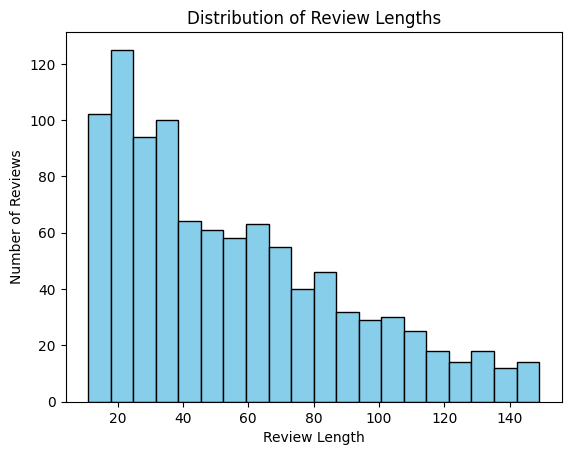

In [6]:
# TODO: plot the length of the reviews
# hint: use the .str.len() method on the first column of the dataframe to get the length of the sentences out
# y axis should be the count/number of reviews
# x axis should be the length of the reviews
# a histogram is a good choice here for visualization
# label your axes!
amz_df['Review Length'] = amz_df[0].str.len()

# Plotting the histogram
plt.hist(amz_df['Review Length'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length')
plt.ylabel('Number of Reviews')
plt.show()

**TODO:** Explore the other two data files, similarly to what we have done above (and what we've done on our homeworks).

In [7]:
# Other data files explored here
imdb_data = "data/datasets/sentiment labelled sentences/imdb_labelled.txt"
imdb_df = pd.read_csv(imdb_data, sep="\t", header=None)
imdb_df

,0,1
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1
...,...,...
743,I just got bored watching Jessice Lange take h...,0
744,"Unfortunately, any virtue in this film's produ...",0
745,"In a word, it is embarrassing.",0
746,Exceptionally bad!,0


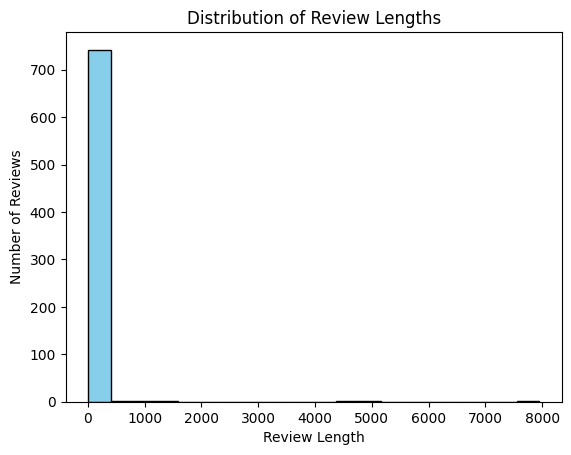

In [8]:
imdb_df['Review Length'] = imdb_df[0].str.len()

# Plotting the histogram
plt.hist(imdb_df['Review Length'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length')
plt.ylabel('Number of Reviews')
plt.show()

In [9]:
# viewing the data
yelp_data = "data/datasets/sentiment labelled sentences/yelp_labelled.txt"
yelp_df = pd.read_csv(yelp_data, sep="\t", header=None)
yelp_df

,0,1
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1
...,...,...
995,I think food should have flavor and texture an...,0
996,Appetite instantly gone.,0
997,Overall I was not impressed and would not go b...,0
998,"The whole experience was underwhelming, and I ...",0


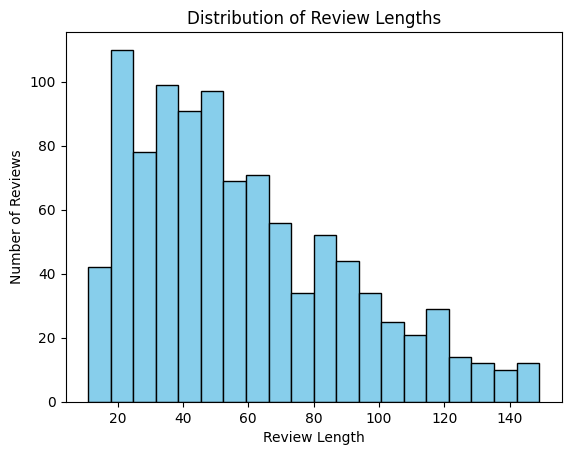

In [10]:
yelp_df['Review Length'] = yelp_df[0].str.len()

# Plotting the histogram
plt.hist(yelp_df['Review Length'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length')
plt.ylabel('Number of Reviews')
plt.show()

## TASK 3: Setting BERT up

__IMPORTANT__:
BERT uses two special tokens while tokenization, they are [CLS] and [SEP]. The [CLS] token is used to capture the overall representation of the input sequence for classification tasks, while the [SEP] token is used to indicate sentence boundaries and separate different segments of text, enabling BERT to understand relationships between sentences. These tokens play a vital role in enabling BERT to handle a wide range of natural language processing tasks effectively.

Let us now begin by understanding the Tokenizer used by BERT and the BERT Model Inputs and Outputs

In [11]:
# import specific models
from transformers import BertTokenizer, TFBertModel

# define a max length constant
MAX_LENGTH = 256

In [12]:
# downloads a bunch of stuff. On Felix's computer (in Meserve Hall), this took ~half a minute
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert = TFBertModel.from_pretrained('bert-base-uncased')

# expect to see:
# Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
# - This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
# - This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
# All the weights of TFBertModel were initialized from the PyTorch model.
# If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [13]:
# TODO: print out a summary of your downloaded bert model
bert.summary()

Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
Total params: 109482240 (417.64 MB)
Trainable params: 109482240 (417.64 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Notice how there are 109M parameters. These parameters have already been trained. We want to make sure these are not trained when we add on our own components later. (We'll "freeze" them.)

1. What kind of text data do these weights encode? (Scour the internet and describe the contents of the data used to train BERT)

    Answer: BERT's weights encode information from a diverse and extensive corpus of internet text, including web pages, articles, books, and various writing styles, to capture a broad understanding of natural language.

## The Tokenizer

In [14]:
# TODO: print out the first 10 tokens in the tokenizer's vocabulary, the
# last ten tokens, and ten tokens from somewhere in the middle of the vocabulary
# print out the things necessary to answer the questions below

# tokenizer.vocab will access the vocabulary
# tokenizer.vocab.keys() will give you the words in the vocabulary. You can convert this to a list to index into it.
# tokenizer.vocab[string] will give you the token id for the string
# tokenizer.decode(id) will give you the string for the token id

# Access the vocabulary
vocab = list(tokenizer.vocab.keys())

# Print the first 10 tokens
print("First 10 tokens:", vocab[:10])

# Print the last 10 tokens
print("Last 10 tokens:", vocab[-10:])

# Print 10 tokens from the middle of the vocabulary
middle_index = len(vocab) // 2
print("Middle 10 tokens:", vocab[middle_index:middle_index + 10])

print("Vocab length is : ",len(tokenizer.vocab))

print("Token at id 2897: ", tokenizer.decode(2897))
print("Token at id 102: ", tokenizer.decode(102))
print("Token at id 103: ", tokenizer.decode(103))

print("My name in vocab?", tokenizer.vocab["tom"])

First 10 tokens: ['[PAD]', '[unused0]', '[unused1]', '[unused2]', '[unused3]', '[unused4]', '[unused5]', '[unused6]', '[unused7]', '[unused8]']
Last 10 tokens: ['##！', '##（', '##）', '##，', '##－', '##．', '##／', '##：', '##？', '##～']
Middle 10 tokens: ['amazed', 'ada', 'elaine', 'supper', '##rth', '##encies', 'predator', 'debated', 'soviets', 'cola']
Vocab length is :  30522
Token at id 2897:  n e t w o r k
Token at id 102:  [ S E P ]
Token at id 103:  [ M A S K ]
My name in vocab? 3419


2. What is the token associated with id 2897? network
3. What is the token associated with id 102? [SEP]
4. What is the token associated with id 103? [MASK]
5. Is your name in BERT's vocabulary (make sure to used the lowercase version, e.g. "felix")? If yes, what is it's id?
    
    Answer: NO, our names are not in Vocab. (We added Tom because none of our names worked)

In [15]:
# example of tokenizing a sentence with the bert tokenizer
input_text = "Hello, my dog is cute, no really"
out = tokenizer(input_text,return_tensors="tf")
for key in out:
    print(key,": ",out[key])

# notice the differences between the input_text and what is printed out here
print(tokenizer.decode(out["input_ids"][0]))

input_ids :  tf.Tensor([[  101  7592  1010  2026  3899  2003 10140  1010  2053  2428   102]], shape=(1, 11), dtype=int32)
token_type_ids :  tf.Tensor([[0 0 0 0 0 0 0 0 0 0 0]], shape=(1, 11), dtype=int32)
attention_mask :  tf.Tensor([[1 1 1 1 1 1 1 1 1 1 1]], shape=(1, 11), dtype=int32)
[CLS] hello, my dog is cute, no really [SEP]


Notice the different keys returned by the tokenizer. The model can take as input all three keys or just one of them the "input_ids".
Since the model requires a fixed length input, we will need to pad the sequences to the same length. Let us pad and turn the sequences into length 15 as an example.

In [16]:
# TODO: set the max_length and truncation parameters of the tokenizer
# the behavior that you want to end up with is a tokenizer that produces tensors that
# are never over 15. You are not providing paired input

# Tokenizer documentation: https://huggingface.co/docs/transformers/main_classes/tokenizer

# Set max_length and truncation
max_len = 15
truncation = True

input_text = "Hello, my dog is not cute, no really"

# TODO: update this line
out = tokenizer(input_text, return_tensors="tf", max_length=max_len, truncation=truncation)

for key in out:
    print(key,": ",out[key])
print(tokenizer.decode(out["input_ids"][0]))

input_ids :  tf.Tensor([[  101  7592  1010  2026  3899  2003  2025 10140  1010  2053  2428   102]], shape=(1, 12), dtype=int32)
token_type_ids :  tf.Tensor([[0 0 0 0 0 0 0 0 0 0 0 0]], shape=(1, 12), dtype=int32)
attention_mask :  tf.Tensor([[1 1 1 1 1 1 1 1 1 1 1 1]], shape=(1, 12), dtype=int32)
[CLS] hello, my dog is not cute, no really [SEP]


The tokenzier also returns multiple outputs for multiple sentences. This is useful for batching.

NOTE : The max length is 512 for BERT. We will use 128 or 256 for this lab (our `MAX_LENGTH` parameter)

In [17]:
# TODO: make a list of sentences that you want to tokenize with at least 3 sentences that are padded to MAX_LENGTH
# make sure that you can tokenize them all at once by looking at the shapes of the tensors that have been output

sentences = [
    "This is the first sentence.",
    "Here is the second sentence, which is a bit longer.",
    "And finally, the third sentence for testing padding and tokenization."
]
batch_x = tokenizer(sentences, return_tensors="tf", padding=True, truncation=True, max_length=MAX_LENGTH)
# here's some code to look at the shapes of the tensors that have been output
for key in batch_x:
    print(key,": ",batch_x[key].shape)

input_ids :  (3, 16)
token_type_ids :  (3, 16)
attention_mask :  (3, 16)


In [18]:
# run bert on the input_ids
out = bert(batch_x["input_ids"])

# display what the keys are for us
out.keys()

odict_keys(['last_hidden_state', 'pooler_output'])

In [19]:
# take a look at the shape of the last_hidden_state
out['last_hidden_state'].shape

TensorShape([3, 16, 768])

The model returns two tensors of interest. One is the pooled output and the other is contextual hidden state over every token. We will use the hidden state associated with the first token [CLS] for classification. Additional strategies involve averaging the non padding states. The pooler output is a summary of the hidden states.

5. Investigate the shape of `last_hidden_state`. What is the __meaning__ of each dimension? (why are each dimension numbered as they are/what do they correspond to? You may need to go investigate some documentation to fully answer this!) __TensorShape([3, 16, 768])- 3: number of sentences that are added to the model. (batch size), 16: max length of the sentence, 768: hidden size in the transformer model__

In [20]:
# we can also run bert with unpacked inputs
out = bert(**batch_x)

# or with them as "input_ids" explicitly
out = bert(input_ids=batch_x["input_ids"])

print("First token [CLS] :")
out["last_hidden_state"][:,0,:]

First token [CLS] :


<tf.Tensor: shape=(3, 768), dtype=float32, numpy=
array([[-0.56318873, -0.16611487, -0.036989  , ..., -0.03010933,
         0.7496735 ,  0.07728498],
       [-0.20429534, -0.07227062,  0.06869503, ..., -0.14972076,
         0.42878544,  0.58831084],
       [-0.19530046, -0.11665301, -0.30326992, ..., -0.2456943 ,
         0.22200522,  0.5340295 ]], dtype=float32)>

## Create a Data Generator

In [21]:
# define a batch size for our experiments
BATCH_SIZE = 8
# define a percentage of the data to use for training
SPLIT_PC = .80

# TODO: caluculate the last index for the training data
total_samples = len(amz_df)

# Calculate the last index for training data
END = int(SPLIT_PC * total_samples)


In [22]:
#  TODO: get the training data and testing data set up
train_df = amz_df.iloc[:END]
test_df = amz_df.iloc[END:]

# TODO: add print statements to verify the sizes of your training/testing data are correct

print("Total samples:", total_samples)
print("Training data size:", len(train_df))
print("Testing data size:", len(test_df))
train_sentences,train_labels = train_df[0], train_df[1]
test_sentences,test_labels = test_df[0], test_df[1]

Total samples: 1000
Training data size: 800
Testing data size: 200


In [23]:
# data generator for the model
def data_generator(sentences: np.array,labels: np.array,batch_size: int) -> (dict,tf.Tensor):
    i = 0
    total_samples = len(sentences)
    while True:
        batch_x = []
        batch_y = []
        # TODO: append batch_size number of sentences and labels to batch_x and batch_y
        # Make sure that you don't re-use sentences and labels that you've already put into batches!
        # YOU PROBABLY WANT A LOOP HERE
        indices = np.random.choice(total_samples, size=batch_size, replace=False)

        batch_x = sentences.iloc[indices].tolist()
        batch_y = labels.iloc[indices]
        # TODO: tokenize the batch_x, padding to MAX_LENGTH, and truncating to MAX_LENGTH
        # batch_x = tokenizer(batch_x, return_tensors='tf', padding=True, truncation=True)
        batch_x = tokenizer(
            batch_x,
            max_length=MAX_LENGTH,
            padding='max_length',
            truncation=True,
            return_tensors='tf'
        )
        # debugging prints (make sure that these are commented out when you actually train your model)
        # should be (batch_size, MAX_LENGTH)
        # print("len: ", batch_x['input_ids'].shape)

        # convert our ys into the appropriate tensor
        batch_y = tf.convert_to_tensor(batch_y)

        # debugging prints (make sure that these are commented out when you actually train your model)
        # should be (batch_size,)
        # print(batch_y.shape)
        yield dict(batch_x), batch_y

train_data = data_generator(train_sentences,train_labels,BATCH_SIZE)
test_data = data_generator(test_sentences,test_labels,BATCH_SIZE)

**"Bonus" Question** - How would you implement randomness in the generator above. (HINT `numpy.random.choice` and its `replace` option)

(This is bonus in the sense that it is a good exercise to think about, not in the sense of us giving you extra credit. Feel free to talk to Prof. Felix more about the intersection of equity and extra credit.)

In [24]:

# TODO: Take a look at the contents of tmp_batch_x and tmp_batch_y and report the shapes of the `input_ids`
# and the y label tensor.
# make sure that the shapes are what you expect them to be
# (take a look at the comments in the data_generator code)

tmp_batch_x,tmp_batch_y = next(train_data)

# Print shapes of input_ids and y label tensor
print("Shape of input_ids:", tmp_batch_x['input_ids'].shape)
print("Shape of y label tensor:", tmp_batch_y.shape)

Shape of input_ids: (8, 256)
Shape of y label tensor: (8,)


## TASK 4: Build the Model

Remember how you used concatenated embeddings for your NN model for HW5. The model we design in this lab will take as input token_ids (batch_size, embedding_dim) , run it through a non-trainable bert, extract the 768 dim vector associated with the [CLS] token of each sentence in a batch, this 768 dim vector will play the role of our concatenated embeddings. The main take away is this : Any input size up to 512 will return a 768 dim vector we can use as an embedding for the entire sentence.

In [25]:
# Build the model
# This takes < 15 sec to run on Felix's computer

bert_model = TFBertModel.from_pretrained('bert-base-uncased',output_attentions = False,return_dict=False)
# we do not need attention outputs
# we want to return tuples since they are easier to access

bert_model.trainable = False
# setting trainable to false ensures
# we do not update its weights
model_ = tf.keras.Sequential([
    bert_model,
    tf.keras.layers.Lambda(lambda x: x[0][:,0,:]), # https://keras.io/api/layers/core_layers/lambda/
    tf.keras.layers.Dense(100,activation="relu"),
    tf.keras.layers.Dense(100,activation="relu"),
    tf.keras.layers.Dense(1,activation="sigmoid")
])

model_.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

1. What does the `Lambda` layer do? Why do we need it? (Read the documentation and investigate. Think carefully about what `x[0][:,0,:]` means. `x[0]` here is a numpy array.)

    Answer: The Lambda layer here picks a specific part of the BERT output, focusing on the first token ([CLS] token) in the sequence. This helps extract important information for further processing.
2. What weights will you be training in this model?

    Answer: The model learns and adjusts the weights in the layers responsible for understanding and predicting, like the layers making sense of BERT's output and the final prediction layer.
2. What weights will you __not__ be training in this model?

    Answer: The BERT part comes with pre-learned knowledge. We don't change those weights during training; they stay as they are. We only tweak the parts that learn from BERT to suit our specific task.

## Train the model

We use `.fit` here

We will also be adding a validation data generator and validation steps.
This will allow us to check accuracy on the test_data wile we train over each epoch.

For this part, you'll be training in some different configurations and __recording your results__. (don't forget to write these down!)

In [26]:
# 2 epochs takes ~2 and a half minutes on Felix's computer
import time
start = time.time()
model_.fit(
    train_data,
    epochs=2,
    batch_size=BATCH_SIZE,
    steps_per_epoch=len(train_sentences)//BATCH_SIZE,
    validation_data=test_data,
    validation_steps=BATCH_SIZE*4,
    validation_batch_size=BATCH_SIZE
)
end = time.time()
print(f"time taken: {end - start}")

Epoch 1/2
100/100 [==============================] - 63s 344ms/step - loss: 0.4258 - accuracy: 0.8050 - val_loss: 0.1919 - val_accuracy: 0.9727
Epoch 2/2
100/100 [==============================] - 29s 288ms/step - loss: 0.2879 - accuracy: 0.8788 - val_loss: 0.1717 - val_accuracy: 0.9375
time taken: 107.35272145271301


TODO: Now train the model on the other two files present in the data folder and report your results (make sure that you train your model from scratch). You will want to experiment with different `MAX_LENGTH`s, `batch_size`s, the number of dense layers you have, the number of hidden units per layer.

In general, the more layers corresponds to the more levels of abstract information that your model will be able to extract/represent. The more hidden units (the "wider") your network has, the more information it will be able to memorize.

4. Using the "base" model settings (the default values we've set for you), record the `val_accuracy` after 2 epochs for each training data set:
    1. imdb: __0.8750__
    2. amazon: __0.95__
    3. yelp: __0.92__

5. Choose one dataset. For at least 4 different combinations of settings, record the following five pieces of information:
    1. training data: amazon
    2. epochs: 2
    3. dimensions of your network (# of layers, # of hidden units per layer) — this is the part after the bert model
    4. `MAX_LENGTH` value
    5. `batch_size` value
    6. time to train
    7. `val_accuracy` in the end
--------------------------------------------------------------------------------
    1. dimensions of your network: # of layers: 3, # of hidden units per layer: 50
    2. `MAX_LENGTH` value: 128
    3. `batch_size` value: 4
    4. time to train: 52s
    5. `val_accuracy` in the end: 0.89
--------------------------------------------------------------------------------
    1. dimensions of your network: # of layers: 3, # of hidden units per layer: 100
    2. `MAX_LENGTH` value: 128
    3. `batch_size` value: 4
    4. time to train: 58s
    5. `val_accuracy` in the end: 0.89
--------------------------------------------------------------------------------
    1. dimensions of your network: # of layers: 3, # of hidden units per layer: 100
    2. `MAX_LENGTH` value: 256
    3. `batch_size` value: 4
    4. time to train: 71s
    5. `val_accuracy` in the end: 0.94
--------------------------------------------------------------------------------
    1. dimensions of your network: # of layers: 3, # of hidden units per layer: 100
    2. `MAX_LENGTH` value: 256
    3. `batch_size` value: 8
    4. time to train: 103s
    5. `val_accuracy` in the end: 0.92



6. What did your experiments show you? __Boosting MAX_LENGTH from 128 to 256 improved the Amazon dataset's validation accuracy, showing that longer reviews help during training. Also, upping the batch size from 4 to 8 increased accuracy and cut training time, indicating larger batches help the model generalize better for this dataset.__